In [3]:
import numpy as np
class TransmissionLine:
    def __init__(self):
        return
    
    def port(self,Z0=50):
        """ Input output port ABCD matrix"""
        return np.matrix(((1,Z0),(0,1)),dtype=complex)
    
    def inport(self, freq, couplingCapacitance):
        n=np.size(freq)
        Zin = 1/(1j*freq*couplingCapacitance)
        return np.append(np.ones(n),[np.zeros(n),Zin,np.ones(n)]).reshape(n,2,2,order='F')
        
    def outport(self, freq, couplingCapacitance):
        n=np.size(freq)
        Zin = 1/(1j*freq*couplingCapacitance)
        return np.append(np.ones(n),[np.zeros(n),Zin,np.ones(n)]).reshape(n,2,2,order='F')
    
    def transmission(self,Z0,beta,length):
        """Transfer matrix
        
        params:
            Z0 : characteristic impedance of the line
            beta : phase constant
            length : length of the transmission line
        
        returns : np.matrix (dtype=complex)
        """
        t11 = np.cosh(beta * length)
        t12 = 1j*Z0*np.sinh(beta*length)
        t21 = 1j*(1/Z0)*np.sinh(beta*length)
        t22 = np.cosh(beta * length)

#         return np.matrix(((a,b),(c,d)),dtype=complex)
        np.append(t11*np.ones(n),[t21*np.ones(n),t12*np.ones(n),t22*np.ones(n)]).reshape(n,2,2,order='F')
    
    def abcd(self,inport,transmission,outport):
        return inport,transmission,outport
    
    def abcd_to_s(self,ABCD,Z0):
        """Convert transfer matrix to S-parameters in magnitude"""
        A = ABCD[0,0]
        B = ABCD[0,1]
        C = ABCD[1,0]
        D = ABCD[1,1]
        S11 = (A + B/Z0 - C/Z0 - D) / (A + B/Z0 + C/Z0 + D)
        S12 = (2*(A*D - B*C)) / (A + B/Z0 + C/Z0 + D)
        S21 = 2 / (A + B/Z0 + C/Z0 + D)
        S22 = (-A + B/Z0 - C/Z0 + D) / (A + B/Z0 + C/Z0 + D)

        return np.matrix(((S11,S12),(S21,S22)),dtype=complex)
    
    def vec_abcd_to_s(self,A,B,C,D,Z0):
        """Convert transfer matrix to S-parameters in magnitude"""
        S11 = (A + B/Z0 - C/Z0 - D) / (A + B/Z0 + C/Z0 + D)
        S12 = (2*(A*D - B*C)) / (A + B/Z0 + C/Z0 + D)
        S21 = 2 / (A + B/Z0 + C/Z0 + D)
        S22 = (-A + B/Z0 - C/Z0 + D) / (A + B/Z0 + C/Z0 + D)

        return S11,S12,S21,S22

    def mag_to_db(self,mag):
        """ Convert magnitude to dB"""
        return 20*np.log10(mag)

In [10]:
tl = TransmissionLine()
print(tl.outport(10,1))

[[[1.0 -0.1j]
  [array([0.]) array([1.])]]]


In [33]:
import ResonatorOptimizer as ro
from matplotlib import pyplot as plt

In [34]:
# Global Parameters
__er = 11.9
__fo = 7.3e09
__h = 500e-06
__t = 50e-09
__pen_depth = 39e-09
__total_width = 43.8e-06
__length = 8102.64e-06

__keyind = lambda X,X_array: min(enumerate(X_array), key=lambda x: abs(x[1]-X))
gap = lambda w: .5*(__total_width - w)

# Test library with capacitively coupled half wavelength resonator

In [35]:
width,length = 4.00e-06,3502.64e-06
cpw= ro.cpwCalcs(width=width, gap=gap(width), length=length, fo=__fo, er=__er, h=__h, t=__t, pen_depth=__pen_depth)
cpw_Z = cpw.impedance_kinetic()

In [50]:
freq = np.arange(2e09,12e09,0.01e09)

tl = TransmissionLine()
beta = np.array([])
a,b,c,d = (np.array([]) for i in range(4))

for i in range(len(freq)):
    beta = np.append(beta,freq[i] * np.sqrt( (cpw.inductance_per_length() + cpw.Lk()*length) * (cpw.capacitance_per_length()) ))
    
    inp = tl.inport(freq[i],1e-12)
    tr = tl.transmission(cpw_Z,beta[i],length)
    outp = tl.outport(freq[i],1e-12)
    abcd = tl.abcd(inp,tr,outp)
#     a,b,c,d = np.append(a,abcd[0,0]), np.append(b,abcd[0,1]), np.append(c,abcd[1,0]), np.append(d,abcd[1,1]) 
#     abcd = tl.transmission_line(low_Z,beta[i],lowZ_length)
#     abcd = np.matmul(tl.port(50),abcd,tl.port(50))
#     a,b,c,d = np.append(a,abcd[0][0][0]), np.append(b,abcd[0,1]), np.append(c,abcd[1,0]), np.append(d,abcd[1,1]) 

abcd[1][0]


matrix([[1.0643503 +0.j        , 0.       +57.36415882j]])

# Define cpw structures

In [5]:
cav_width,cav_length = 4.00e-06,3502.64e-06
cavity= ro.cpwCalcs(width=cav_width, gap=gap(cav_width), length=cav_length, fo=__fo, er=__er, h=__h, t=__t, pen_depth=__pen_depth)
cav_Z = cavity.impedance_kinetic()

In [6]:
lowZ_width,lowZ_length = 10.0e-06,cav_length+14e-06
Zlow = ro.cpwCalcs(width=lowZ_width, gap=gap(lowZ_width), length=lowZ_length, fo=__fo, er=__er, h=__h, t=__t, pen_depth=__pen_depth)
low_Z = Zlow.impedance_kinetic()

In [7]:
highZ_width,highZ_length = 2.50e-06,cav_length - cav_length/2 - 736.55e-06
Zhigh = ro.cpwCalcs(width=highZ_width, gap=gap(highZ_width), length=highZ_length, fo=__fo, er=__er, h=__h, t=__t, pen_depth=__pen_depth)
high_Z = Zhigh.impedance_kinetic()

# Calculate transmission properties

In [12]:
freq = np.arange(2e09,12e09,0.01e09)

tl = TransmissionLine()
beta = np.array([])
a,b,c,d = (np.array([]) for i in range(4))

for i in range(len(freq)):
    beta = np.append(beta,freq[i] * np.sqrt( (cavity.inductance_per_length() + cavity.Lk()*cav_length) * (cavity.capacitance_per_length()) ))
    abcd = tl.transmission_line(low_Z,beta[i],lowZ_length)
    abcd = np.matmul(tl.port(50),abcd,tl.port(50))
    a,b,c,d = np.append(a,abcd[0,0]), np.append(b,abcd[0,1]), np.append(c,abcd[1,0]), np.append(d,abcd[1,1]) 
abcd

matrix([[ 1.06487124+2.36992102e-01j, 53.24356214+2.82605966e+01j],
        [ 0.        +4.73984204e-03j,  1.06487124+0.00000000e+00j]])

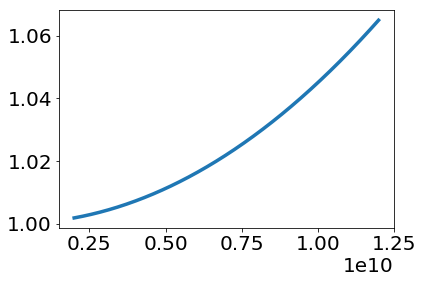

In [16]:
plt.plot(freq,d)
plt.show()

In [72]:
a

array([1.00178633+0.j, 1.00180425+0.j, 1.00182225+0.j, 1.00184034+0.j,
       1.00185852+0.j, 1.00187679+0.j, 1.00189516+0.j, 1.00191361+0.j,
       1.00193214+0.j, 1.00195077+0.j, 1.00196949+0.j, 1.0019883 +0.j,
       1.0020072 +0.j, 1.00202618+0.j, 1.00204526+0.j, 1.00206443+0.j,
       1.00208368+0.j, 1.00210303+0.j, 1.00212246+0.j, 1.00214198+0.j,
       1.0021616 +0.j, 1.0021813 +0.j, 1.00220109+0.j, 1.00222097+0.j,
       1.00224095+0.j, 1.00226101+0.j, 1.00228116+0.j, 1.0023014 +0.j,
       1.00232173+0.j, 1.00234214+0.j, 1.00236265+0.j, 1.00238325+0.j,
       1.00240394+0.j, 1.00242471+0.j, 1.00244558+0.j, 1.00246654+0.j,
       1.00248758+0.j, 1.00250872+0.j, 1.00252994+0.j, 1.00255125+0.j,
       1.00257266+0.j, 1.00259415+0.j, 1.00261573+0.j, 1.0026374 +0.j,
       1.00265916+0.j, 1.00268102+0.j, 1.00270296+0.j, 1.00272499+0.j,
       1.00274711+0.j, 1.00276931+0.j, 1.00279161+0.j, 1.002814  +0.j,
       1.00283648+0.j, 1.00285905+0.j, 1.0028817 +0.j, 1.00290445+0.j,
      

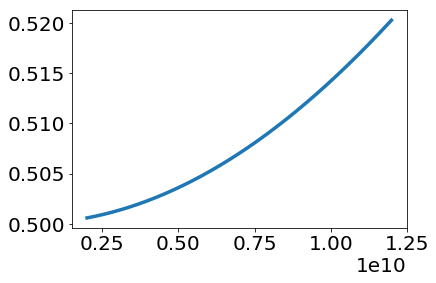

In [83]:
freq = np.arange(2e09,12e09,0.01e09)












beta = np.zeros((len(freq)),dtype=complex)
a = np.zeros((len(freq)),dtype=complex)
b = np.zeros((len(freq)),dtype=complex)
c = np.zeros((len(freq)),dtype=complex)
d = np.zeros((len(freq)),dtype=complex)
lowZ_c = np.zeros((len(freq)),dtype=complex)
highZ_c = np.zeros((len(freq)),dtype=complex)

tl = TransmissionLine()

for i in range(len(freq)):

    beta[i] = freq[i] * np.sqrt( (cavity.inductance_per_length() + cavity.Lk()*cav_length) * (cavity.capacitance_per_length()) )
    
    inp = tl.port(Z0=50)
    low_transmission = tl.abcd(low_Z, beta[i],lowZ_length)    
    high_transmission = tl.abcd(high_Z,beta[i],highZ_length) 
    outp = tl.port(Z0=50)
    abcd = inp * low_transmission * high_transmission * outp    
    a[i] = abcd[0,0]
    b[i] = abcd[0,1]
    c[i] = abcd[1,0]
    d[i] = abcd[1,1]

S11,S12,S21,S22 = tl.vec_abcd_to_s(a,b,c,d,50)

plt.plot(freq,S22)
plt.show()
#     highZ_s_params = abcd_to_s(transfer,high_Z)
#     highZ_s21[i] = highZ_s_params[1,0]



In [ ]:
freq = np.arange(2e09,12e09,.0005e09)
beta = np.zeros((len(freq)),dtype=float)
lowZ_s11 = np.zeros((len(freq)),dtype=complex)
lowZ_s12 = np.zeros((len(freq)),dtype=complex)
lowZ_s21 = np.zeros((len(freq)),dtype=complex)
lowZ_s22 = np.zeros((len(freq)),dtype=complex)

highZ_s11 = np.zeros((len(freq)),dtype=complex)
highZ_s12 = np.zeros((len(freq)),dtype=complex)
highZ_s21 = np.zeros((len(freq)),dtype=complex)
highZ_s22 = np.zeros((len(freq)),dtype=complex)


for i in range(len(freq)):
    beta[i] = freq[i] * np.sqrt( (cavity.inductance_per_length() + cavity.Lk()*cav_length) * (cavity.capacitance_per_length()) )
    transfer = abcd(low_Z, beta[i],lowZ_length)
    lowZ_s_params = abcd_to_s(transfer,low_Z)
    lowZ_s11[i] = lowZ_s_params[0,0]
    lowZ_s12[i] = lowZ_s_params[0,1]
    lowZ_s21[i] = lowZ_s_params[1,0]
    lowZ_s22[i] = lowZ_s_params[1,1]
    
    highZ_s_params = abcd_to_s(transfer,high_Z)
    highZ_s11[i] = highZ_s_params[0,0]
    highZ_s12[i] = highZ_s_params[0,1]
    highZ_s21[i] = highZ_s_params[1,0]
    highZ_s22[i] = highZ_s_params[1,1]

In [31]:
I = np.matrix(((1,0),(0,1)),dtype=float)
b = np.matrix(((2,0),(0,2)),dtype=float)
np.append((b,I),axis=1)

TypeError: append() missing 1 required positional argument: 'values'